In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])
for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:24<00:00,  2.21s/it]

DONE!


In [2]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [1]:
# =======================
# STEP 1: IMPORTS & CONFIG
# =======================
import os
import random
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# -------- Config class --------
class CFG:
    # EI PATH TA CHANGE KORTE HOBE
    DATA_DIR = "/kaggle/input/fishes/Fishes"  # Fishes folder er absolute path

    BATCH_SIZE =16
    NUM_WORKERS = 2
    EPOCHS = 20              # SimCLR training epochs
    LR = 1e-3
    TEMPERATURE = 0.5        # SimCLR temperature
    FEATURE_DIM = 128        # projection head er output size
    IMAGE_SIZE = 224
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LINEAR_EPOCHS = 10
    MAX_TSNE_POINTS = 1500   # t-SNE-er jonno maximum sample
    PRINT_FREQ = 50

cfg = CFG()

# -------- Reproducibility --------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

print("Device:", cfg.DEVICE)
print("Data dir:", cfg.DATA_DIR)


Device: cuda
Data dir: /kaggle/input/fishes/Fishes


In [2]:
# =======================
# STEP 2: DATA & AUGMENTATIONS
# =======================
# Gaussian blur for SimCLR
class GaussianBlur(object):
    def __init__(self, kernel_size=23, sigma=(0.1, 2.0)):
        self.blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

    def __call__(self, x):
        return self.blur(x)

# SimCLR style transform (duita view)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=23),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Normal eval transform
eval_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Dataset: 2 ta augmented view + ekta clean view
class SimCLRDataset(Dataset):
    def __init__(self, root, transform=None, eval_transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform is not None:
            xi = self.transform(img)
            xj = self.transform(img)
        else:
            xi = xj = img

        if self.eval_transform is not None:
            x_clean = self.eval_transform(img)
        else:
            x_clean = None

        return xi, xj, x_clean, label

# SimCLR training dataset
simclr_dataset = SimCLRDataset(
    root=cfg.DATA_DIR,
    transform=simclr_transform,
    eval_transform=eval_transform
)

num_classes = len(simclr_dataset.dataset.classes)
print("Number of classes:", num_classes)
print("Classes:", simclr_dataset.dataset.classes)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

# Evaluation dataset (clean images only)
eval_dataset = ImageFolder(
    root=cfg.DATA_DIR,
    transform=eval_transform
)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)


Number of classes: 21
Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [11]:
# =======================
# STEP 3: MODEL (RESNET50 + PROJECTION HEAD)
# =======================
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        # Different torchvision version handle:
        try:
            backbone = resnet50(weights=None if not pretrained else 'IMAGENET1K_V1')
        except TypeError:
            backbone = resnet50(pretrained=pretrained)
        backbone.fc = nn.Identity()     # classification head remove
        self.backbone = backbone
        self.out_dim = 2048

    def forward(self, x):
        return self.backbone(x)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = F.normalize(x, dim=1)
        return x

class SimCLR(nn.Module):
    def __init__(self, temperature=0.5, feature_dim=128, pretrained_backbone=False):
        super().__init__()
        self.temperature = temperature
        self.encoder = ResNet50Encoder(pretrained=pretrained_backbone)
        self.projector = ProjectionHead(self.encoder.out_dim, feature_dim)

    def forward(self, xi, xj):
        hi = self.encoder(xi)
        hj = self.encoder(xj)
        zi = self.projector(hi)
        zj = self.projector(hj)
        return hi, hj, zi, zj


In [12]:
# =======================
# STEP 4: NT-Xent LOSS
# =======================
def nt_xent_loss(zi, zj, temperature):
    """
    zi, zj : [N, D]
    """
    N = zi.size(0)
    z = torch.cat([zi, zj], dim=0)         # [2N, D]
    z = F.normalize(z, dim=1)

    # cosine similarity matrix
    sim = torch.matmul(z, z.T)             # [2N, 2N]
    sim = sim / temperature

    # self-similarity mask
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    # positive indices: for i in [0..N-1] -> i+N, for i in [N..2N-1] -> i-N
    labels = torch.cat([
        torch.arange(N, 2 * N),
        torch.arange(0, N)
    ]).to(z.device)

    loss = F.cross_entropy(sim, labels)
    return loss


In [13]:
import gc, torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

CUDA cache cleared.


In [14]:
# =======================
# STEP 5: TRAINING LOOP (50 EPOCHS, 3 TEMPERATURE, FAST)
# =======================
import gc, torch, time
import matplotlib.pyplot as plt

def train_simclr(model, dataloader, epochs, lr, temperature, max_steps_per_epoch=None):
    model.to(cfg.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for step, (xi, xj, _, _) in enumerate(dataloader):
            # per-epoch batch limit (time kom rakhte)
            if (max_steps_per_epoch is not None) and (step >= max_steps_per_epoch):
                break

            xi = xi.to(cfg.DEVICE, non_blocking=True)
            xj = xj.to(cfg.DEVICE, non_blocking=True)

            optimizer.zero_grad()
            _, _, zi, zj = model(xi, xj)
            loss = nt_xent_loss(zi, zj, temperature)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

            if (step + 1) % cfg.PRINT_FREQ == 0:
                print(
                    f"T={temperature} | "
                    f"Epoch [{epoch}/{epochs}] Step [{step+1}/{len(dataloader)}] "
                    f"Loss: {loss.item():.4f}"
                )

        scheduler.step()
        avg_loss = epoch_loss / max(1, n_batches)
        loss_history.append(avg_loss)
        print(
            f"T={temperature} | "
            f"Epoch [{epoch}/{epochs}] Avg Loss: {avg_loss:.4f} "
            f"| Time: {time.time()-t0:.1f}s, Batches: {n_batches}"
        )

    return model, loss_history


# ---------- MULTI-TEMP TRAINING ----------
TEMPERATURES = [0.1, 0.2, 0.5]
NUM_EPOCHS = 2
MAX_STEPS_PER_EPOCH = 40   # iccha hole 30/50 korle time change hobe

all_loss_histories = {}    # {temp: [loss_per_epoch]}
all_models = {}            # {temp: trained_simclr_model}  <-- IMPORTANT

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Training SimCLR for T = {temp}")
    print("="*60)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    simclr_model = SimCLR(
        temperature=temp,
        feature_dim=cfg.FEATURE_DIM,
        pretrained_backbone=False
    )

    simclr_model, loss_history = train_simclr(
        simclr_model,
        simclr_loader,
        epochs=NUM_EPOCHS,
        lr=cfg.LR,
        temperature=temp,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH
    )

    # ekhane dui ta important line:
    all_loss_histories[temp] = loss_history   # loss store
    all_models[temp] = simclr_model           # model store

    



Training SimCLR for T = 0.1
T=0.1 | Epoch [1/2] Avg Loss: 3.2983 | Time: 98.9s, Batches: 36
T=0.1 | Epoch [2/2] Avg Loss: 3.1414 | Time: 88.4s, Batches: 36

Training SimCLR for T = 0.2
T=0.2 | Epoch [1/2] Avg Loss: 3.3456 | Time: 83.7s, Batches: 36
T=0.2 | Epoch [2/2] Avg Loss: 3.0916 | Time: 86.7s, Batches: 36

Training SimCLR for T = 0.5
T=0.5 | Epoch [1/2] Avg Loss: 3.3085 | Time: 88.5s, Batches: 36
T=0.5 | Epoch [2/2] Avg Loss: 3.1438 | Time: 84.0s, Batches: 36


In [15]:
import torch
import os

save_dir = "/kaggle/working/simclr_models"
os.makedirs(save_dir, exist_ok=True)

for temp in [0.1, 0.2, 0.5]:
    save_path = f"{save_dir}/simclr_resnet50_T{temp}_80epochs.pth"
    torch.save(all_models[temp].state_dict(), save_path)
    print(f"Model saved for T={temp}: {save_path}")


Model saved for T=0.1: /kaggle/working/simclr_models/simclr_resnet50_T0.1_80epochs.pth
Model saved for T=0.2: /kaggle/working/simclr_models/simclr_resnet50_T0.2_80epochs.pth
Model saved for T=0.5: /kaggle/working/simclr_models/simclr_resnet50_T0.5_80epochs.pth


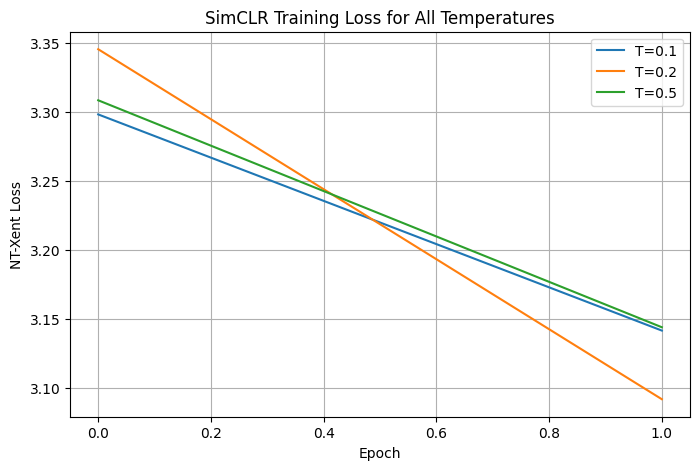

In [16]:
# STEP 6: LOSS CURVE FOR ALL TEMPERATURES

plt.figure(figsize=(8, 5))

for temp in all_loss_histories:
    losses = all_loss_histories[temp]
    plt.plot(losses, label=f"T={temp}")

plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.title("SimCLR Training Loss for All Temperatures")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# =========================
# STEP 7: MULTI-TEMP FEATURE EXTRACTION
# =========================

import torch
import numpy as np

# jodi age define na thake, tahole ekbar define kore nao:
def extract_features(backbone, dataloader, max_samples=None):
    backbone.to(cfg.DEVICE)
    backbone.eval()

    feats_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            feats = backbone(imgs)
            feats = feats.view(feats.size(0), -1)

            feats_list.append(feats.cpu())
            labels_list.append(labels.cpu())

            if max_samples is not None:
                if sum(len(x) for x in labels_list) >= max_samples:
                    break

    features = torch.cat(feats_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(labels) > max_samples:
        features = features[:max_samples]
        labels = labels[:max_samples]

    return features.numpy(), labels.numpy()


# ei dictionary gula te sob temperature-er feature thakbe
features_by_temp = {}
labels_by_temp = {}

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nExtracting features for T = {temp}")

    # Step 5 e ensure korecho:
    # all_models[temp] = simclr_model
    backbone = all_models[temp].encoder

    feats, labs = extract_features(
        backbone,
        eval_loader,
        max_samples=cfg.MAX_TSNE_POINTS  # chaile None dile full data
    )

    features_by_temp[temp] = feats
    labels_by_temp[temp] = labs

    print(f"T={temp} → Features: {feats.shape}, Labels: {labs.shape}")



Extracting features for T = 0.1
T=0.1 → Features: (583, 2048), Labels: (583,)

Extracting features for T = 0.2
T=0.2 → Features: (583, 2048), Labels: (583,)

Extracting features for T = 0.5
T=0.5 → Features: (583, 2048), Labels: (583,)



Running t-SNE for T = 0.1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 583 samples in 0.001s...
[t-SNE] Computed neighbors for 583 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 583 / 583
[t-SNE] Mean sigma: 4.082057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.432564
[t-SNE] KL divergence after 1000 iterations: 0.444719


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


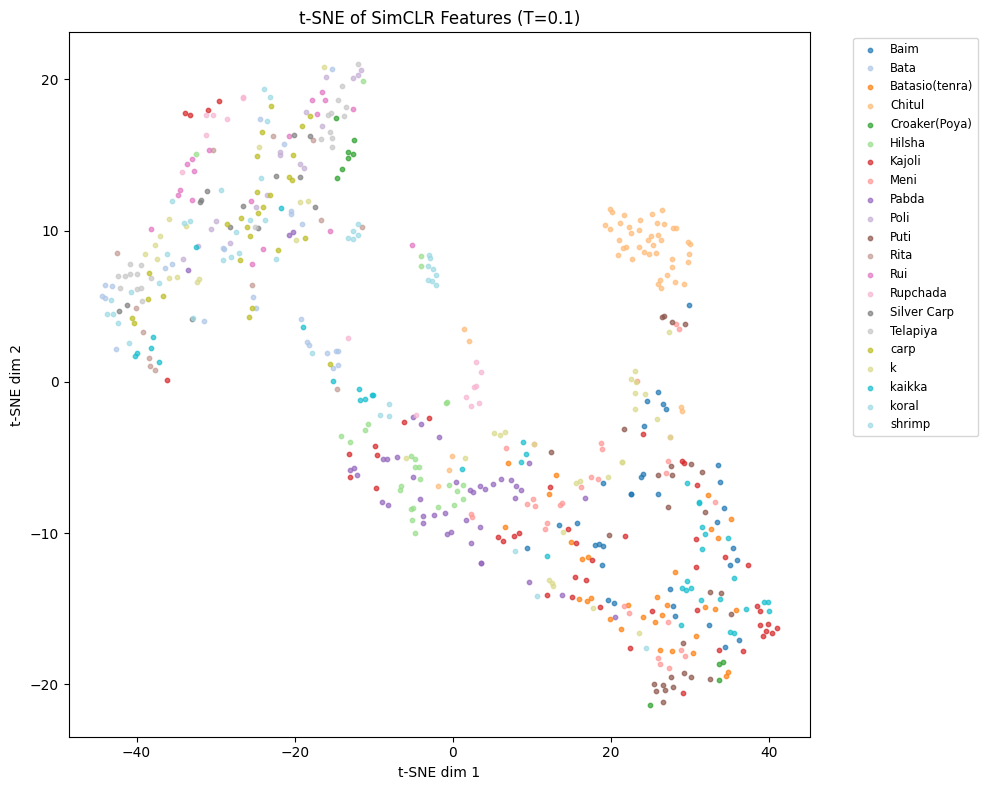


Running t-SNE for T = 0.2
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 583 samples in 0.001s...
[t-SNE] Computed neighbors for 583 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 583 / 583
[t-SNE] Mean sigma: 1.649777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.099346
[t-SNE] KL divergence after 1000 iterations: 0.324959


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


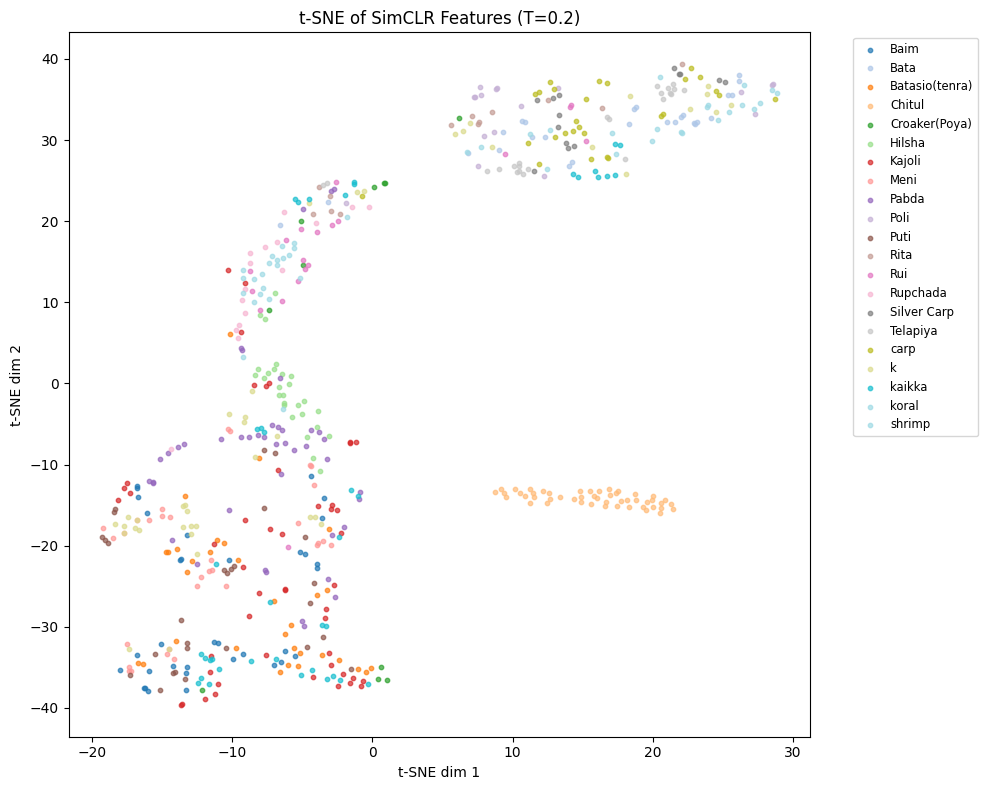


Running t-SNE for T = 0.5
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 583 samples in 0.001s...
[t-SNE] Computed neighbors for 583 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 583 / 583
[t-SNE] Mean sigma: 4.898281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.139198
[t-SNE] KL divergence after 1000 iterations: 0.366053


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


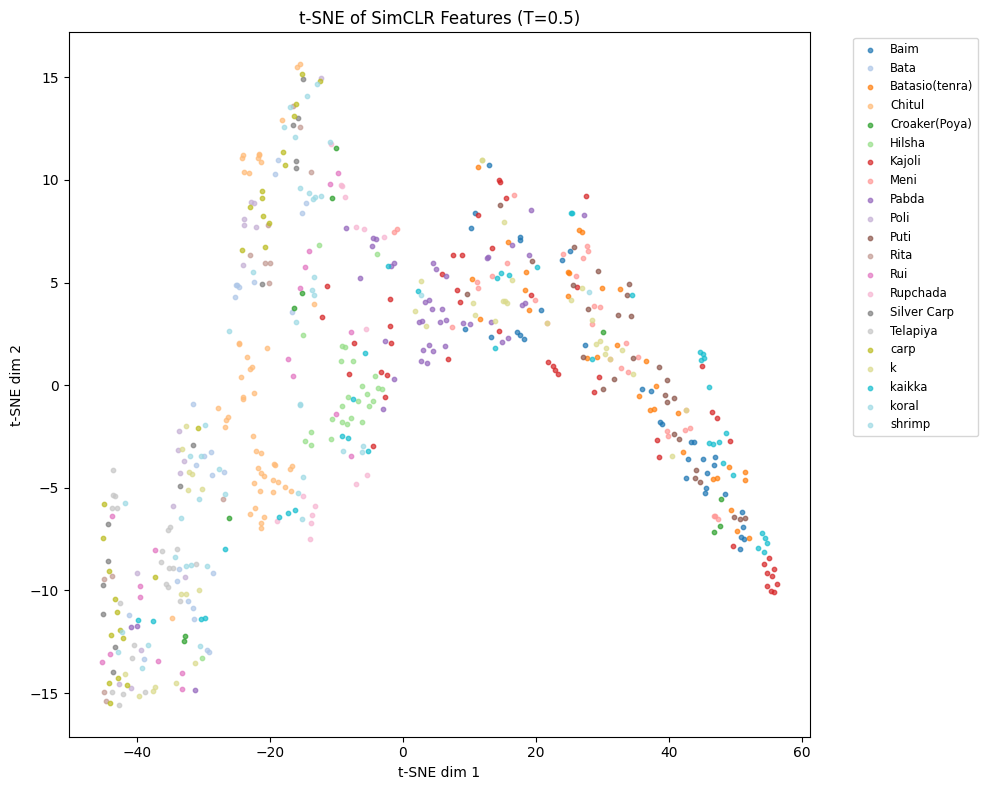

In [18]:
# =========================
# STEP 8: t-SNE FOR EACH TEMPERATURE
# =========================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nRunning t-SNE for T = {temp}")

    tsne_features = features_by_temp[temp]
    tsne_labels = labels_by_temp[temp]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        verbose=1,
        random_state=cfg.SEED
    )

    tsne_results = tsne.fit_transform(tsne_features)

    plt.figure(figsize=(10, 8))

    num_classes = len(eval_dataset.classes)
    colors = plt.cm.get_cmap('tab20', num_classes)

    for class_id in range(num_classes):
        idx = tsne_labels == class_id
        if np.sum(idx) == 0:
            continue
        plt.scatter(
            tsne_results[idx, 0],
            tsne_results[idx, 1],
            s=10,
            alpha=0.7,
            c=[colors(class_id)],
            label=eval_dataset.classes[class_id]
        )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(f"t-SNE of SimCLR Features (T={temp})")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()



Linear Evaluation for Temperature = 0.1
Features: (583, 2048) Labels: (583,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy for T=0.1: 65.81%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.80      0.57      0.67         7
          Bata       0.60      0.60      0.60         5
Batasio(tenra)       0.50      0.50      0.50         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      1.00      1.00         2
        Hilsha       1.00      1.00      1.00         5
        Kajoli       1.00      0.50      0.67        10
          Meni       0.62      0.83      0.71         6
         Pabda       0.67      0.89      0.76         9
          Poli       0.50      1.00      0.67         3
          Puti       0.67      0.67      0.67         6
          Rita       0.50      0.67      0.57         3
           Rui       0.33      0.25      0.29         4
      Rupchada       0.75      1.00      0.86         3
   Silver Carp       0.50      0.33      0.40         3
      Telapiya       1.00      0.60      0.75      

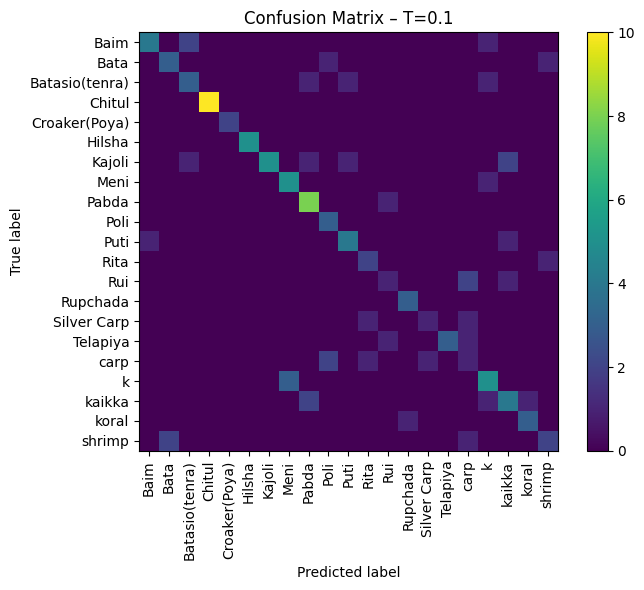


Linear Evaluation for Temperature = 0.2
Features: (583, 2048) Labels: (583,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy for T=0.2: 64.96%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.67      0.57      0.62         7
          Bata       0.80      0.80      0.80         5
Batasio(tenra)       0.25      0.17      0.20         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      0.50      0.67         2
        Hilsha       1.00      1.00      1.00         5
        Kajoli       0.64      0.70      0.67        10
          Meni       0.45      0.83      0.59         6
         Pabda       0.89      0.89      0.89         9
          Poli       0.00      0.00      0.00         3
          Puti       0.50      0.33      0.40         6
          Rita       1.00      0.33      0.50         3
           Rui       0.25      0.25      0.25         4
      Rupchada       0.33      0.33      0.33         3
   Silver Carp       0.50      0.67      0.57         3
      Telapiya       1.00      1.00      1.00      

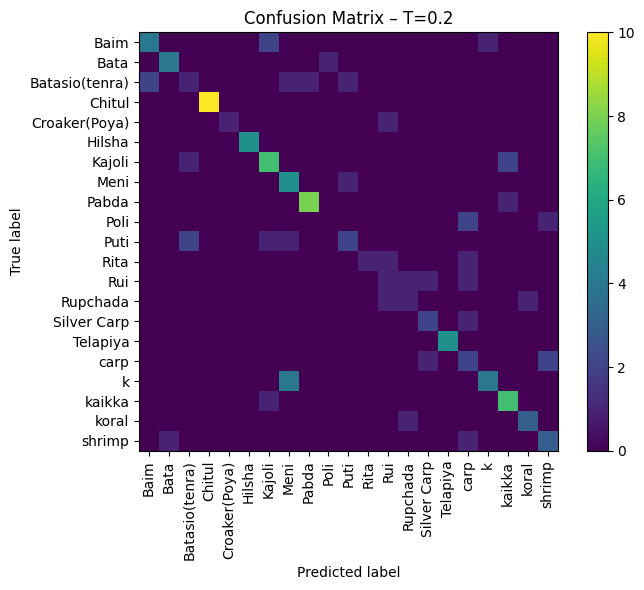


Linear Evaluation for Temperature = 0.5
Features: (583, 2048) Labels: (583,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit


Accuracy for T=0.5: 61.54%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.50      0.57      0.53         7
          Bata       0.62      1.00      0.77         5
Batasio(tenra)       0.80      0.67      0.73         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      0.50      0.67         2
        Hilsha       0.71      1.00      0.83         5
        Kajoli       0.62      0.50      0.56        10
          Meni       0.60      1.00      0.75         6
         Pabda       0.58      0.78      0.67         9
          Poli       0.20      0.33      0.25         3
          Puti       0.75      0.50      0.60         6
          Rita       0.00      0.00      0.00         3
           Rui       0.33      0.25      0.29         4
      Rupchada       0.40      0.67      0.50         3
   Silver Carp       0.33      0.33      0.33         3
      Telapiya       1.00      0.80      0.89      

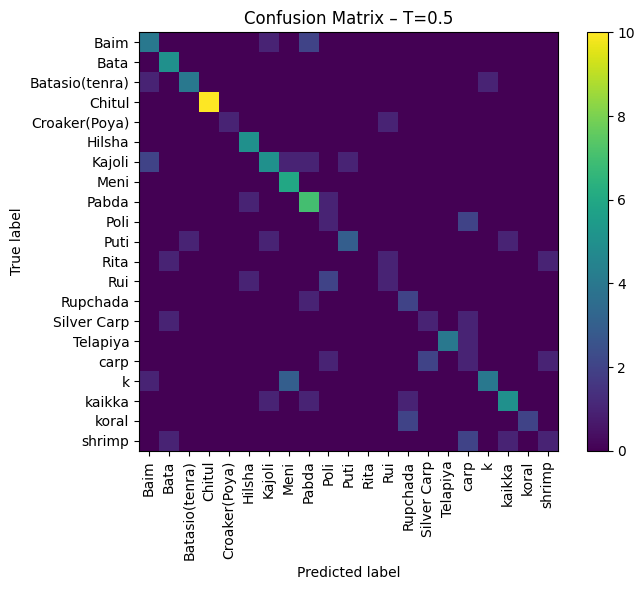


ACCURACY SUMMARY TABLE:
   Temperature  Accuracy (%)
0          0.1     65.811966
1          0.2     64.957265
2          0.5     61.538462


In [19]:
# =========================
# STEP 9: MULTI-TEMP LINEAR EVALUATION + CONFUSION MATRIX HEATMAP
# =========================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

temperature_results = {}   # sob result ekhane store hobe

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Linear Evaluation for Temperature = {temp}")
    print("="*60)

    # backbone from that temperature's SimCLR model
    backbone = all_models[temp].encoder

    # full dataset-er feature extract
    all_features, all_labels = extract_features(
        backbone,
        eval_loader,
        max_samples=None
    )

    print("Features:", all_features.shape, "Labels:", all_labels.shape)

    # train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        all_features,
        all_labels,
        test_size=0.2,
        random_state=cfg.SEED,
        stratify=all_labels
    )

    # Logistic Regression (linear classifier)
    linear_clf = LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    )
    linear_clf.fit(X_train, y_train)

    # predictions
    y_pred = linear_clf.predict(X_val)

    # accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"\nAccuracy for T={temp}: {acc * 100:.2f}%")

    # classification report
    print("\nClassification Report:")
    print(classification_report(
        y_val, y_pred, target_names=eval_dataset.classes
    ))

    # confusion matrix (numeric)
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix (numeric):")
    print(cm)

    # confusion matrix er visual heatmap
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix – T={temp}")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    num_classes = len(eval_dataset.classes)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, eval_dataset.classes, rotation=90)
    plt.yticks(tick_marks, eval_dataset.classes)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

    # save all info
    temperature_results[temp] = {
        "accuracy": acc,
        "y_true": y_val,
        "y_pred": y_pred,
        "confusion_matrix": cm
    }

# small summary table of all temperatures
summary = {
    "Temperature": [],
    "Accuracy (%)": []
}

for temp in TEMPERATURES:
    summary["Temperature"].append(temp)
    summary["Accuracy (%)"].append(temperature_results[temp]["accuracy"] * 100)

df_summary = pd.DataFrame(summary)
print("\nACCURACY SUMMARY TABLE:")
print(df_summary)


In [20]:
# ======================================
# CELL 2: SHALLOW HEADS ON FROZEN FEATURES
# MLP, SVM, Decision Tree, Random Forest
# ======================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

shallow_results = {}  # {temp: {model_name: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Shallow heads for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    models = {
        "MLP": make_pipeline(
            StandardScaler(),
            MLPClassifier(hidden_layer_sizes=(256, 128),
                          max_iter=300,
                          random_state=cfg.SEED)
        ),
        "SVM": make_pipeline(
            StandardScaler(),
            SVC(kernel="rbf", probability=True, random_state=cfg.SEED)
        ),
        "DecisionTree": DecisionTreeClassifier(
            max_depth=None,
            random_state=cfg.SEED
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=cfg.SEED,
            n_jobs=-1
        )
    }

    shallow_results[temp] = {}

    for name, clf in models.items():
        print(f"\n--- Training {name} ---")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        shallow_results[temp][name] = acc

        print(f"{name} Accuracy (T={temp}): {acc*100:.2f}%")
        print("Classification report:")
        print(classification_report(
            y_val, y_pred, target_names=eval_dataset.classes
        ))



Shallow heads for T = 0.1

--- Training MLP ---
MLP Accuracy (T=0.1): 64.10%
Classification report:
                precision    recall  f1-score   support

          Baim       1.00      0.57      0.73         7
          Bata       0.56      1.00      0.71         5
Batasio(tenra)       0.38      0.50      0.43         6
        Chitul       1.00      0.90      0.95        10
 Croaker(Poya)       1.00      1.00      1.00         2
        Hilsha       0.71      1.00      0.83         5
        Kajoli       0.67      0.40      0.50        10
          Meni       0.56      0.83      0.67         6
         Pabda       0.55      0.67      0.60         9
          Poli       0.75      1.00      0.86         3
          Puti       0.67      0.33      0.44         6
          Rita       0.50      0.33      0.40         3
           Rui       1.00      0.50      0.67         4
      Rupchada       1.00      0.67      0.80         3
   Silver Carp       0.33      0.33      0.33         3
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTree Accuracy (T=0.1): 47.86%
Classification report:
                precision    recall  f1-score   support

          Baim       0.17      0.14      0.15         7
          Bata       0.50      0.60      0.55         5
Batasio(tenra)       0.38      0.50      0.43         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      1.00      1.00         2
        Hilsha       0.75      0.60      0.67         5
        Kajoli       0.56      0.50      0.53        10
          Meni       0.36      0.67      0.47         6
         Pabda       0.55      0.67      0.60         9
          Poli       0.00      0.00      0.00         3
          Puti       0.75      0.50      0.60         6
          Rita       0.25      0.33      0.29         3
           Rui       0.50      0.25      0.33         4
      Rupchada       0.67      0.67      0.67         3
   Silver Carp       0.00      0.00      0.00         3
      Telapiya       0.40      0.40      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest Accuracy (T=0.1): 62.39%
Classification report:
                precision    recall  f1-score   support

          Baim       0.33      0.29      0.31         7
          Bata       0.71      1.00      0.83         5
Batasio(tenra)       1.00      0.50      0.67         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      1.00      1.00         2
        Hilsha       1.00      1.00      1.00         5
        Kajoli       0.40      0.40      0.40        10
          Meni       0.57      0.67      0.62         6
         Pabda       0.73      0.89      0.80         9
          Poli       0.38      1.00      0.55         3
          Puti       0.50      0.33      0.40         6
          Rita       1.00      0.33      0.50         3
           Rui       1.00      0.25      0.40         4
      Rupchada       0.75      1.00      0.86         3
   Silver Carp       1.00      0.33      0.50         3
      Telapiya       0.80      0.80      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Accuracy (T=0.2): 37.61%
Classification report:
                precision    recall  f1-score   support

          Baim       0.22      0.29      0.25         7
          Bata       0.00      0.00      0.00         5
Batasio(tenra)       0.14      0.17      0.15         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       0.00      0.00      0.00         2
        Hilsha       0.83      1.00      0.91         5
        Kajoli       0.67      0.40      0.50        10
          Meni       0.36      0.67      0.47         6
         Pabda       0.28      0.56      0.37         9
          Poli       0.00      0.00      0.00         3
          Puti       0.00      0.00      0.00         6
          Rita       0.00      0.00      0.00         3
           Rui       0.50      0.25      0.33         4
      Rupchada       0.00      0.00      0.00         3
   Silver Carp       0.00      0.00      0.00         3
      Telapiya       0.00      0.00      0.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTree Accuracy (T=0.2): 41.03%
Classification report:
                precision    recall  f1-score   support

          Baim       0.38      0.43      0.40         7
          Bata       0.50      0.20      0.29         5
Batasio(tenra)       0.25      0.17      0.20         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       0.00      0.00      0.00         2
        Hilsha       0.50      0.40      0.44         5
        Kajoli       0.86      0.60      0.71        10
          Meni       0.29      0.33      0.31         6
         Pabda       0.43      0.33      0.38         9
          Poli       0.33      0.33      0.33         3
          Puti       0.33      0.50      0.40         6
          Rita       0.25      0.33      0.29         3
           Rui       0.00      0.00      0.00         4
      Rupchada       0.00      0.00      0.00         3
   Silver Carp       0.33      0.33      0.33         3
      Telapiya       0.33      0.40      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest Accuracy (T=0.2): 58.12%
Classification report:
                precision    recall  f1-score   support

          Baim       0.67      0.57      0.62         7
          Bata       0.71      1.00      0.83         5
Batasio(tenra)       0.25      0.17      0.20         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      0.50      0.67         2
        Hilsha       0.83      1.00      0.91         5
        Kajoli       0.70      0.70      0.70        10
          Meni       0.38      0.50      0.43         6
         Pabda       0.50      0.78      0.61         9
          Poli       0.00      0.00      0.00         3
          Puti       0.40      0.33      0.36         6
          Rita       1.00      0.33      0.50         3
           Rui       0.20      0.25      0.22         4
      Rupchada       0.00      0.00      0.00         3
   Silver Carp       0.50      0.33      0.40         3
      Telapiya       1.00      0.80      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLP Accuracy (T=0.5): 65.81%
Classification report:
                precision    recall  f1-score   support

          Baim       0.62      0.71      0.67         7
          Bata       0.45      1.00      0.62         5
Batasio(tenra)       1.00      0.50      0.67         6
        Chitul       1.00      1.00      1.00        10
 Croaker(Poya)       1.00      0.50      0.67         2
        Hilsha       0.83      1.00      0.91         5
        Kajoli       0.67      0.60      0.63        10
          Meni       0.55      1.00      0.71         6
         Pabda       0.73      0.89      0.80         9
          Poli       0.40      0.67      0.50         3
          Puti       0.75      0.50      0.60         6
          Rita       0.00      0.00      0.00         3
           Rui       1.00      0.50      0.67         4
      Rupchada       0.67      0.67      0.67         3
   Silver Carp       1.00      0.33      0.50         3
      Telapiya       1.00      0.80      0.89      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTree Accuracy (T=0.5): 42.74%
Classification report:
                precision    recall  f1-score   support

          Baim       0.57      0.57      0.57         7
          Bata       0.50      0.40      0.44         5
Batasio(tenra)       0.43      0.50      0.46         6
        Chitul       0.90      0.90      0.90        10
 Croaker(Poya)       0.50      0.50      0.50         2
        Hilsha       0.20      0.20      0.20         5
        Kajoli       0.38      0.30      0.33        10
          Meni       0.50      0.50      0.50         6
         Pabda       0.40      0.44      0.42         9
          Poli       0.14      0.33      0.20         3
          Puti       0.38      0.50      0.43         6
          Rita       0.00      0.00      0.00         3
           Rui       1.00      0.25      0.40         4
      Rupchada       0.33      0.33      0.33         3
   Silver Carp       1.00      0.33      0.50         3
      Telapiya       0.50      0.60      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# ======================================
# CELL 3: FULL FINE-TUNING (BEST TEMP)
# ======================================
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

best_temp = 0.5   # jeta ke best dhorcho (change korte parba)
backbone = all_models[best_temp].encoder.backbone  # torchvision ResNet

num_classes = len(eval_dataset.classes)

class FineTuneResNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        in_dim = 2048
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

# full dataset = eval_dataset (ImageFolder)
full_dataset = eval_dataset

# 80% train, 20% val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(cfg.SEED)
)

train_loader_ft = DataLoader(
    train_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

val_loader_ft = DataLoader(
    val_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

model_ft = FineTuneResNet(backbone, num_classes).to(cfg.DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-4)
EPOCHS_FT = 10

for epoch in range(1, EPOCHS_FT + 1):
    model_ft.train()
    train_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader_ft:
        imgs = imgs.to(cfg.DEVICE)
        labels = labels.to(cfg.DEVICE)

        optimizer.zero_grad()
        logits = model_ft(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = logits.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total * 100

    # validation
    model_ft.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader_ft:
            imgs = imgs.to(cfg.DEVICE)
            labels = labels.to(cfg.DEVICE)

            logits = model_ft(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            _, preds = logits.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total * 100

    print(f"[FT T={best_temp}] Epoch {epoch}/{EPOCHS_FT} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# training শেষ হলে save করো
save_path = "fish_classifier_resnet50_ft.pth"
torch.save({
    "model_state": model_ft.state_dict(),
    "class_names": eval_dataset.classes
}, save_path)
print("Saved:", save_path)



[FT T=0.5] Epoch 1/10 Train Loss: 2.6303, Train Acc: 19.96% | Val Loss: 2.0496, Val Acc: 23.08%
[FT T=0.5] Epoch 2/10 Train Loss: 2.0140, Train Acc: 30.04% | Val Loss: 1.8670, Val Acc: 40.17%
[FT T=0.5] Epoch 3/10 Train Loss: 1.9307, Train Acc: 34.98% | Val Loss: 1.7522, Val Acc: 36.75%
[FT T=0.5] Epoch 4/10 Train Loss: 1.7065, Train Acc: 39.91% | Val Loss: 1.8248, Val Acc: 41.03%
[FT T=0.5] Epoch 5/10 Train Loss: 1.4971, Train Acc: 54.51% | Val Loss: 1.3729, Val Acc: 54.70%
[FT T=0.5] Epoch 6/10 Train Loss: 1.2978, Train Acc: 56.44% | Val Loss: 1.5119, Val Acc: 45.30%
[FT T=0.5] Epoch 7/10 Train Loss: 1.0819, Train Acc: 65.88% | Val Loss: 1.1328, Val Acc: 58.97%
[FT T=0.5] Epoch 8/10 Train Loss: 1.0177, Train Acc: 68.88% | Val Loss: 1.2272, Val Acc: 58.97%
[FT T=0.5] Epoch 9/10 Train Loss: 0.9561, Train Acc: 66.74% | Val Loss: 0.8557, Val Acc: 72.65%
[FT T=0.5] Epoch 10/10 Train Loss: 0.6725, Train Acc: 80.90% | Val Loss: 1.1797, Val Acc: 59.83%
Saved: fish_classifier_resnet50_ft.pth


In [22]:
# ===== COMPAT PATCH FOR UMAP + OLD SKLEARN =====
import umap.umap_ as umap_mod
from sklearn.utils.validation import check_array as sk_check_array

def check_array_compat(*args, **kwargs):
    # umap sometimes passes ensure_all_finite, but old sklearn doesn't accept it
    kwargs.pop("ensure_all_finite", None)
    return sk_check_array(*args, **kwargs)

umap_mod.check_array = check_array_compat
print("Patched UMAP check_array() for sklearn compatibility.")


2025-12-09 19:17:15.510605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765307835.900797      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765307836.017713      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Patched UMAP check_array() for sklearn compatibility.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 71.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.

Embedding Analysis for T = 0.1


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


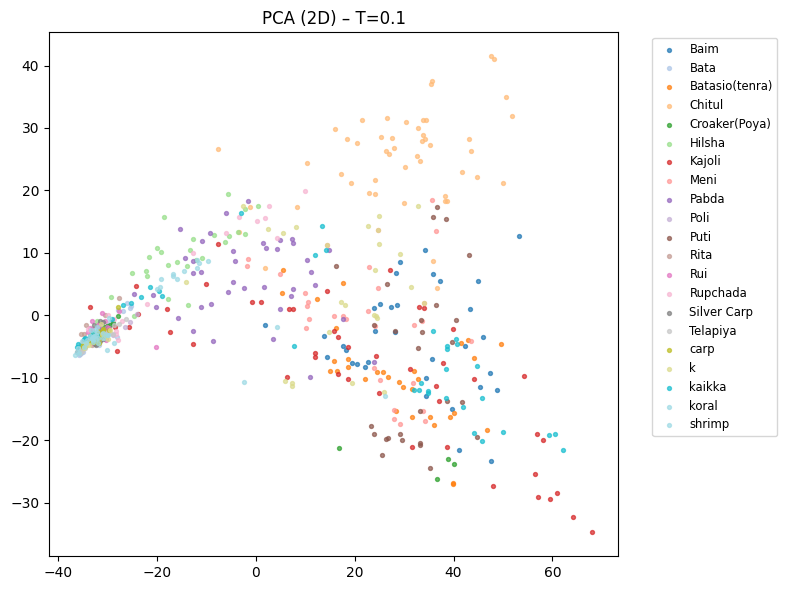

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


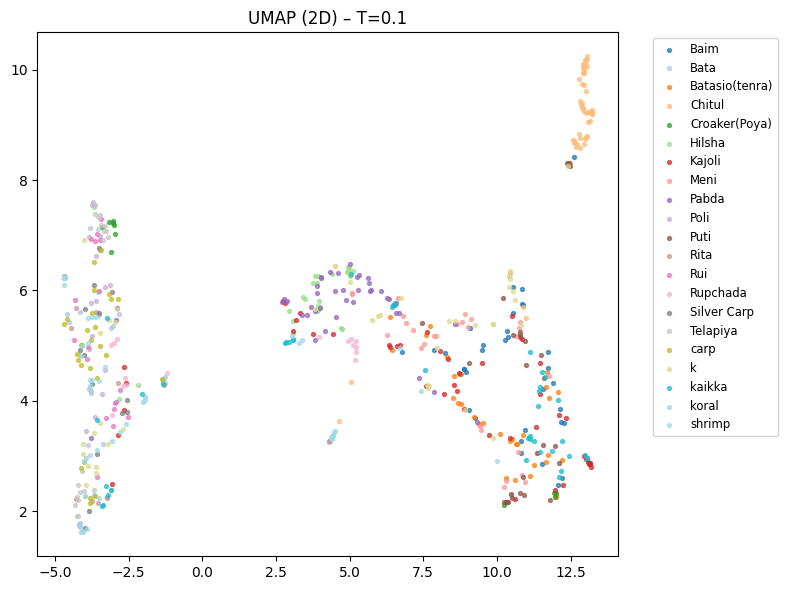

Silhouette score (T=0.1): -0.1679

Embedding Analysis for T = 0.2


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


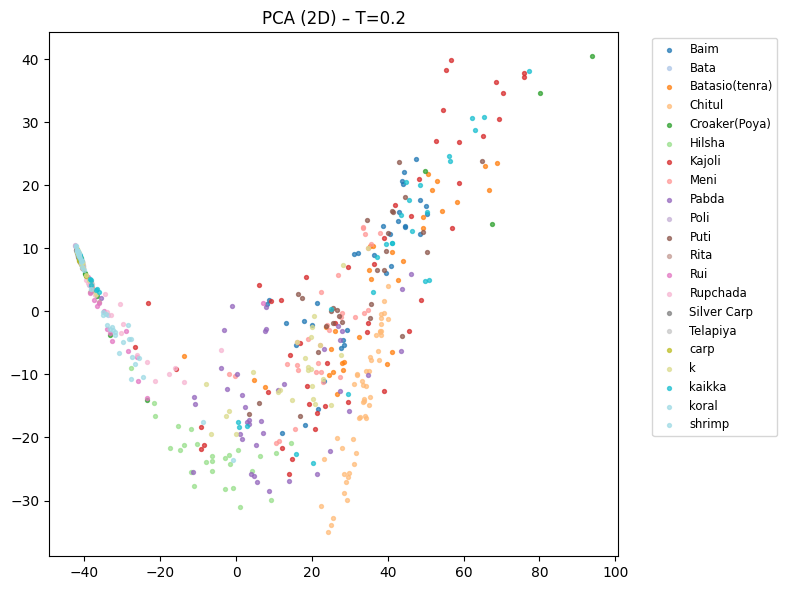

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


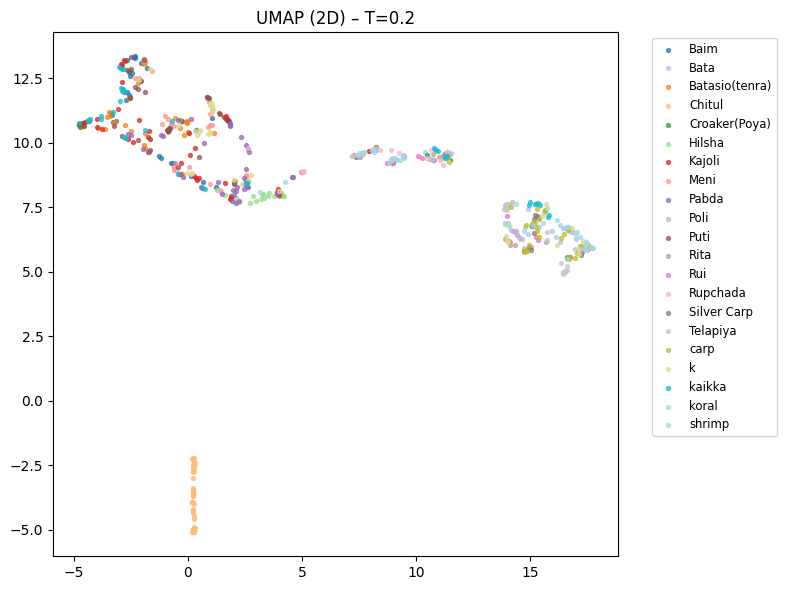

Silhouette score (T=0.2): -0.1744

Embedding Analysis for T = 0.5


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


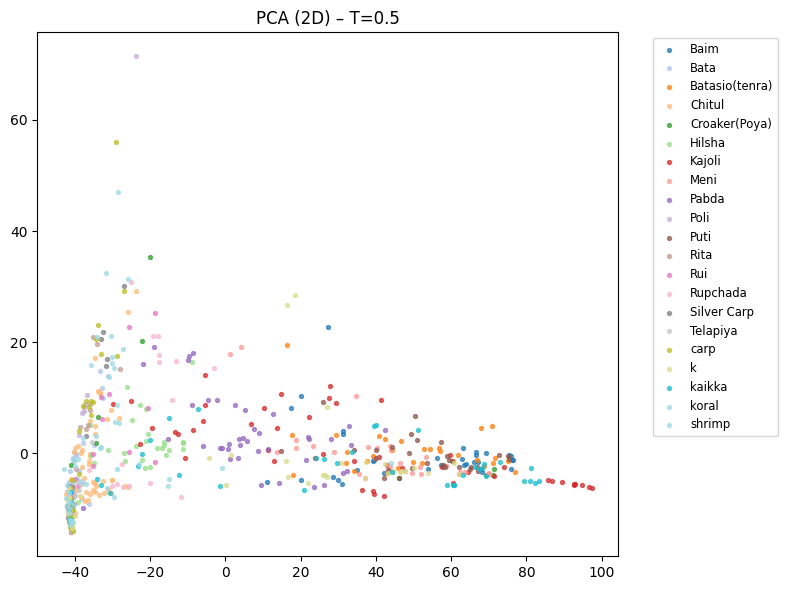

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


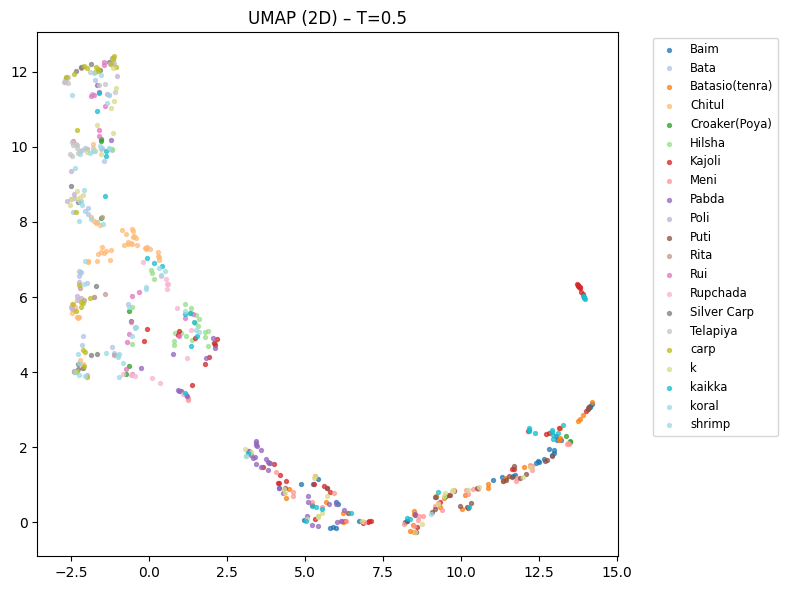

Silhouette score (T=0.5): -0.2212


In [23]:
# ======================================
# CELL 4: UMAP, PCA, SILHOUETTE SCORE
# ======================================
!pip install -q umap-learn

import umap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Embedding Analysis for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    # --- PCA 2D ---
    pca = PCA(n_components=2, random_state=cfg.SEED)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    num_classes = len(eval_dataset.classes)
    colors = plt.cm.get_cmap("tab20", num_classes)

    for c in range(num_classes):
        idx = (y == c)
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                    s=8, alpha=0.7, c=[colors(c)], label=eval_dataset.classes[c])
    plt.title(f"PCA (2D) – T={temp}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

    # --- UMAP 2D ---
    reducer = umap.UMAP(
        n_components=2,
        random_state=cfg.SEED,
        n_neighbors=15,
        min_dist=0.1
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        idx = (y == c)
        plt.scatter(X_umap[idx, 0], X_umap[idx, 1],
                    s=8, alpha=0.7, c=[colors(c)], label=eval_dataset.classes[c])
    plt.title(f"UMAP (2D) – T={temp}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

    # --- Silhouette score (w.r.t true labels) ---
    sil = silhouette_score(X, y)
    print(f"Silhouette score (T={temp}): {sil:.4f}")



In [24]:
# ======================================
# CELL 5: k-NN ACCURACY IN EMBEDDING SPACE
# ======================================
from sklearn.neighbors import KNeighborsClassifier

knn_results = {}  # {temp: {k: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"k-NN accuracy for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    knn_results[temp] = {}
    for k in [1, 5, 20]:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        knn_results[temp][k] = acc
        print(f"k = {k}, T={temp} → Accuracy: {acc*100:.2f}%")



k-NN accuracy for T = 0.1
k = 1, T=0.1 → Accuracy: 61.54%
k = 5, T=0.1 → Accuracy: 53.85%
k = 20, T=0.1 → Accuracy: 38.46%

k-NN accuracy for T = 0.2
k = 1, T=0.2 → Accuracy: 60.68%
k = 5, T=0.2 → Accuracy: 46.15%
k = 20, T=0.2 → Accuracy: 38.46%

k-NN accuracy for T = 0.5
k = 1, T=0.5 → Accuracy: 52.99%
k = 5, T=0.5 → Accuracy: 44.44%
k = 20, T=0.5 → Accuracy: 31.62%



Label Efficiency for T = 0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.1 → Acc: 22.22%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.1 → Acc: 23.08%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.1 → Acc: 28.21%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=25% labels, T=0.1 → Acc: 41.03%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=50% labels, T=0.1 → Acc: 60.68%

Label Efficiency for T = 0.2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.2 → Acc: 23.08%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.2 → Acc: 25.64%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.2 → Acc: 34.19%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed`

Frac=25% labels, T=0.2 → Acc: 46.15%
Frac=50% labels, T=0.2 → Acc: 60.68%

Label Efficiency for T = 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.5 → Acc: 21.37%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.5 → Acc: 23.08%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.5 → Acc: 23.93%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=25% labels, T=0.5 → Acc: 37.61%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=50% labels, T=0.5 → Acc: 51.28%


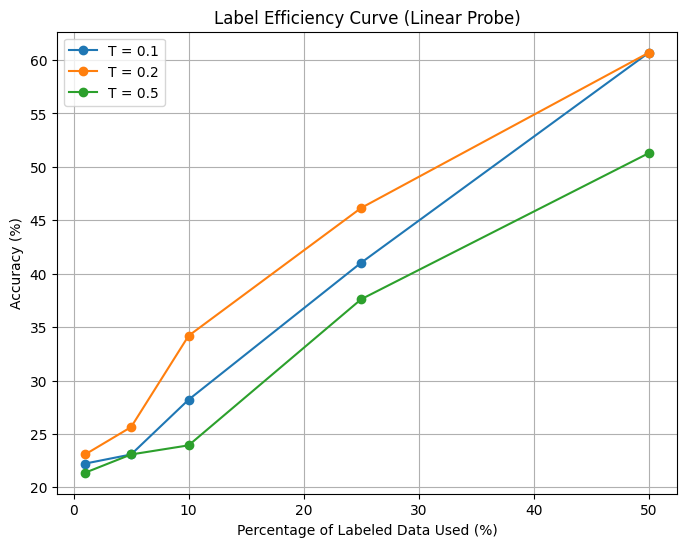

In [25]:
# ======================================
# CELL 6: LABEL-EFFICIENCY CURVES (LINEAR PROBE)
# ======================================
fractions = [0.01, 0.05, 0.10, 0.25, 0.50]

from sklearn.linear_model import LogisticRegression

label_efficiency = {}  # {temp: {fraction: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Label Efficiency for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_full_train, X_val, y_full_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    label_efficiency[temp] = {}

    for frac in fractions:
        n_samples = int(len(X_full_train) * frac)
        if n_samples < len(np.unique(y)):
            n_samples = len(np.unique(y))

        # Select only frac% of labeled data
        X_sub, _, y_sub, _ = train_test_split(
            X_full_train, y_full_train,
            train_size=n_samples,
            random_state=cfg.SEED,
            stratify=y_full_train
        )

        # Train linear classifier
        clf = LogisticRegression(max_iter=2000, n_jobs=-1)
        clf.fit(X_sub, y_sub)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        label_efficiency[temp][frac] = acc
        print(f"Frac={frac*100:.0f}% labels, T={temp} → Acc: {acc*100:.2f}%")

# ======================================
# PLOT LABEL EFFICIENCY CURVE (3 TEMPS)
# ======================================
plt.figure(figsize=(8, 6))

for temp in TEMPERATURES:
    accs = [label_efficiency[temp][f] * 100 for f in fractions]
    plt.plot([f * 100 for f in fractions], accs, marker="o", label=f"T = {temp}")

plt.title("Label Efficiency Curve (Linear Probe)")
plt.xlabel("Percentage of Labeled Data Used (%)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Macro ROC–AUC (T=0.5): 0.9548


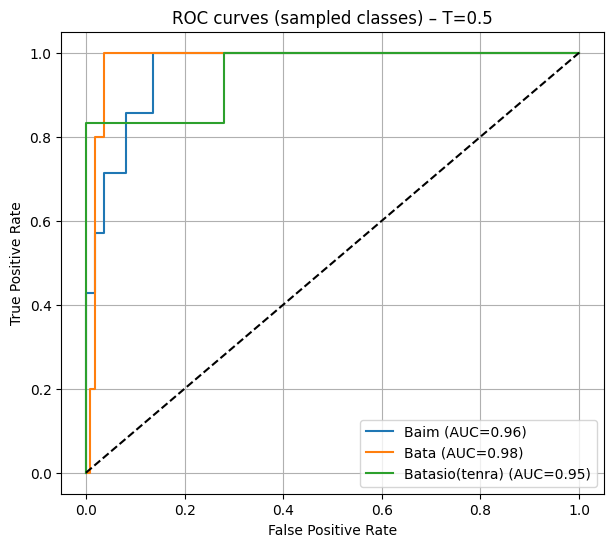

In [26]:
# ======================================
# CELL 7: ROC–AUC & ROC CURVE (BEST TEMP, LINEAR PROBE)
# ======================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

best_temp = 0.5   # jeta ke best dhorcho
X = features_by_temp[best_temp]
y = labels_by_temp[best_temp]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2,
    random_state=cfg.SEED,
    stratify=y
)

# Logistic regression with probability
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_val)
y_bin = label_binarize(y_val, classes=np.arange(len(eval_dataset.classes)))

roc_auc_macro = roc_auc_score(y_bin, y_proba, multi_class="ovr", average="macro")
print(f"Macro ROC–AUC (T={best_temp}): {roc_auc_macro:.4f}")

# example: plot ROC curve for 3 random classes or first 3
plt.figure(figsize=(7, 6))
for i in range(min(3, y_proba.shape[1])):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{eval_dataset.classes[i]} (AUC={auc_i:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves (sampled classes) – T={best_temp}")
plt.legend()
plt.grid(True)
plt.show()
